In [3]:
# 原文地址：https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# 翻译转载：https://github.com/YukonKong/Chinese-version.Deep-Learning-with-PyTorch-A-60-Minute-Blitz

Training a Classifier （训练一个分类器）
=====================

This is it. You have seen how to define neural networks, compute loss
and make updates to the weights of the network.

这就是它。你已经看到了如何定义神经网络、计算损失以及更新网络的权重。

Now you might be thinking,

现在你可能正在想，

What about data?

对于数据的处理呢？
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a `torch.*Tensor`.

通常，当您需要处理图像、文本、音频或视频数据时，您可以使用标准的 Python 包将数据加载到 numpy 数组中。然后，您可以将此数组转换为 torch.*Tensor 。

-   For images, packages such as Pillow, OpenCV are useful

    对于图像，Pillow、OpenCV 等软件包很有用
-   For audio, packages such as scipy and librosa

    音频方面，如 scipy 和 librosa 等包
-   For text, either raw Python or Cython based loading, or NLTK and
    SpaCy are useful
    
    对于文本，无论是基于原始 Python 或 Cython 的加载，还是 NLTK 和 SpaCy 都很有用

Specifically for vision, we have created a package called `torchvision`,
that has data loaders for common datasets such as ImageNet, CIFAR10,
MNIST, etc. and data transformers for images, viz.,
`torchvision.datasets` and `torch.utils.data.DataLoader`.

专门针对视觉，我们创建了一个名为 torchvision 的包，其中包含常见数据集（如 ImageNet、CIFAR10、MNIST 等）的数据加载器以及图像数据转换器，即 torchvision.datasets 和 torch.utils.data.DataLoader 。

This provides a huge convenience and avoids writing boilerplate code.

这提供了极大的便利，避免了编写模板代码。

For this tutorial, we will use the CIFAR10 dataset. It has the classes:
'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
'ship', 'truck'. The images in CIFAR-10 are of size 3x32x32, i.e.
3-channel color images of 32x32 pixels in size.

为此教程，我们将使用 CIFAR10 数据集。它包含以下类别：'飞机'、'汽车'、'鸟'、'猫'、'鹿'、'狗'、'青蛙'、'马'、'船'、'卡车'。CIFAR-10 中的图像大小为 3x32x32，即 32x32 像素大小的 3 通道彩色图像。

![cifar10](https://pytorch.org/tutorials/_static/img/cifar10.png)

Training an image classifier （训练图像分类器）
----------------------------

We will do the following steps in order:

我们将按以下步骤依次进行：

1.  Load and normalize the CIFAR10 training and test datasets using
    `torchvision`

    加载并使用 torchvision 归一化 CIFAR10 训练和测试数据集

2.  Define a Convolutional Neural Network
    
    定义卷积神经网络

3.  Define a loss function

    定义损失函数

4.  Train the network on the training data

    在训练数据上训练网络

5.  Test the network on the test data

    在测试数据上测试网络


### 1. Load and normalize CIFAR10 （加载并归一化 CIFAR10）

Using `torchvision`, it's extremely easy to load CIFAR10.

使用 torchvision ，加载 CIFAR10 极其简单。

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range \[0,
1\]. We transform them to Tensors of normalized range \[-1, 1\].

其输出图像为范围[0, 1]的 PILImage 图像。我们将它们转换为范围[-1, 1]的归一化张量。

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p>If running on Windows and you get a BrokenPipeError, try settingthe num_worker of torch.utils.data.DataLoader() to 0.</p>
</div>

注意：如果在 Windows 上运行并遇到 BrokenPipeError，请尝试将 torch.utils.data.DataLoader()的 num_worker 设置为 0。

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.

让我们展示一些训练图像，图个乐。

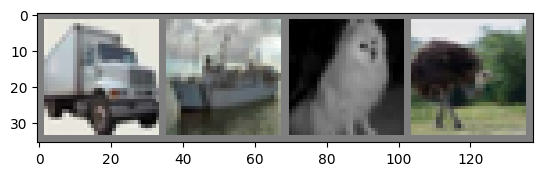

truck ship  dog   bird 


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 显示图像的函数


def imshow(img):
    img = img / 2 + 0.5     # 反归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 获取一些随机的训练图像
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 显示图形
imshow(torchvision.utils.make_grid(images))
# 打印标签
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network （定义一个卷积神经网络）

Copy the neural network from the Neural Networks section before and
modify it to take 3-channel images (instead of 1-channel images as it
was defined).

复制神经网络，并将其修改为接受 3 通道图像（而不是之前定义的 1 通道图像）。

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # 将除了批处理之外的所有维度展平

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. Define a Loss function and optimizer （定义损失函数和优化器）

Let\'s use a Classification Cross-Entropy loss and SGD with momentum.

让我们使用分类交叉熵损失和具有动量的随机梯度下降法。


In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4.Train the network （训练这个网络）

This is when things start to get interesting. We simply have to loop
over our data iterator, and feed the inputs to the network and optimize.

这正是事情变得有趣的时候。我们只需遍历我们的数据迭代器，将输入提供给网络并优化即可。

In [9]:
for epoch in range(2):  # 遍历数据集多次

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入; 数据是一个包含[输入, 标签]的列表
        inputs, labels = data

        # 清零参数梯度
        optimizer.zero_grad()

        # 向前传播 + 反向传播 + 优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印统计信息
        running_loss += loss.item()
        if i % 2000 == 1999:  # 每2000个小批量打印一次

            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.203
[1,  4000] loss: 1.859
[1,  6000] loss: 1.691
[1,  8000] loss: 1.607
[1, 10000] loss: 1.525
[1, 12000] loss: 1.464
[2,  2000] loss: 1.409
[2,  4000] loss: 1.384
[2,  6000] loss: 1.338
[2,  8000] loss: 1.337
[2, 10000] loss: 1.296
[2, 12000] loss: 1.303
Finished Training


Let\'s quickly save our trained model:

让我们快速保存我们训练完成的模型：

In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html) for
more details on saving PyTorch models.

请在此处查看有关保存 PyTorch 模型的更多详细信息。

### 5. Test the network on the test data （在测试数据上测试网络）

We have trained the network for 2 passes over the training dataset. But
we need to check if the network has learnt anything at all.

我们已经在训练数据集上训练了网络两次。但我们需要检查网络是否真的“学到了一些东西”。

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

我们把通过神经网络预测输出的类别标签与真实标签进行比对来验证这一点。如果预测正确，我们将该样本添加到正确预测列表中。

Okay, first step. Let us display an image from the test set to get
familiar.

好的，第一步。让我们展示测试集中的一个图像，以便熟悉。


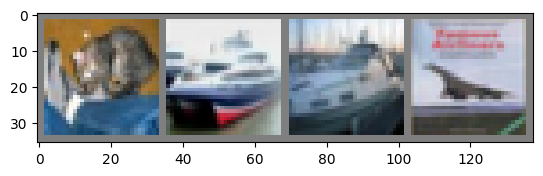

GroundTruth:  cat   ship  ship  plane


In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# 打印图像
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let\'s load back in our saved model (note: saving and re-loading
the model wasn\'t necessary here, we only did it to illustrate how to do
so):

接下来，让我们重新加载我们保存的模型（注意：在此处保存和重新加载模型并非必要，我们这样做只是为了说明如何进行操作）：


In [12]:
net = Net()
net.load_state_dict(torch.load(PATH))

C:\Users\tmp\AppData\Local\Temp\ipykernel_18880\238682776.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above
are:

好的，现在让我们看看神经网络认为上述例子是什么：

In [13]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a
class, the more the network thinks that the image is of the particular
class. So, let\'s get the index of the highest energy:

输出是 10 个类别的“能量”。一个类别的能量越高，网络就越认为图像属于该类别。因此，让我们找到能量最高的索引：


In [19]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   dog   deer  horse


The results seem pretty good.

结果看起来相当不错。

Let us look at how the network performs on the whole dataset.

让我们看看网络在整个数据集上的表现。


In [15]:
correct = 0
total = 0
# 因为我们没有在训练，所以我们不需要计算输出梯度
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 通过将图像传递给网络来计算输出
        outputs = net(images)
        # 能量最高的那一类就是我们选择作为预测结果
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


That looks way better than chance, which is 10% accuracy (randomly
picking a class out of 10 classes). Seems like the network learnt
something.

这比随机选择（从 10 个类别中随机选择一个类别）的 10% 准确率要好得多。看起来网络学到了一些东西。

Hmmm, what are the classes that performed well, and the classes that did
not perform well:

emmm，那么对于哪些类别的判断表现良好，对于哪些类别表现不佳：


In [16]:
# 准备统计每个类的预测结果
correct_pred = {classname: 0 for classname in classes}

total_pred = {classname: 0 for classname in classes}


# 同样不需要计算梯度

with torch.no_grad():
    for data in testloader:

        images, labels = data

        outputs = net(images)

        _, predictions = torch.max(outputs, 1)

        # 收集每个类的正确预测结果

        for label, prediction in zip(labels, predictions):

            if label == prediction:

                correct_pred[classes[label]] += 1

            total_pred[classes[label]] += 1


# 打印每个类的准确率

for classname, correct_count in correct_pred.items():

    accuracy = 100 * float(correct_count) / total_pred[classname]

    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 56.9 %
Accuracy for class: car   is 65.3 %
Accuracy for class: bird  is 24.1 %
Accuracy for class: cat   is 39.5 %
Accuracy for class: deer  is 62.8 %
Accuracy for class: dog   is 53.6 %
Accuracy for class: frog  is 60.3 %
Accuracy for class: horse is 64.0 %
Accuracy for class: ship  is 70.0 %
Accuracy for class: truck is 61.6 %


Okay, so what next?

好的，那么接下来是什么？

How do we run these neural networks on the GPU?

如何在 GPU 上运行这些神经网络？

Training on GPU （在 GPU 上进行训练）
===============

Just like how you transfer a Tensor onto the GPU, you transfer the
neural net onto the GPU.

就像您将张量传输到 GPU 上一样，您将神经网络传输到 GPU 上。

Let\'s first define our device as the first visible cuda device if we
have CUDA available:

首先如果 CUDA 可用，则定义我们的首选设备为 CUDA ：


In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 假设我们在一个CUDA机器上，打印结果应为一个CUDA设备：

print(device)

cpu


The rest of this section assumes that `device` is a CUDA device.

本节其余部分假设使用的 device 是一个 CUDA 设备。


Then these methods will recursively go over all modules and convert
their parameters and buffers to CUDA tensors:

然后这些方法将递归地遍历所有模块，并将它们的参数和缓冲区转换为 CUDA 张量：

``` {.sourceCode .python}
net.to(device)
```

Remember that you will have to send the inputs and targets at every step
to the GPU too:

请记住，您必须在每个步骤中将输入和目标发送到 GPU：

``` {.sourceCode .python}
inputs, labels = data[0].to(device), data[1].to(device)
```

Why don\'t I notice MASSIVE speedup compared to CPU? Because your
network is really small.

为什么我没有注意到与 CPU 相比的显著加速？因为你的网络很小。

**Exercise （练习）:** Try increasing the width of your network (argument 2 of
the first `nn.Conv2d`, and argument 1 of the second `nn.Conv2d` -- they
need to be the same number), see what kind of speedup you get.

尝试增加您网络的宽度（第一个 nn.Conv2d 的第 2 个参数，以及第二个 nn.Conv2d 的第 1 个参数需要是相同的数字），看看能得到什么样的加速效果。

**Goals achieved （目标达成）**:

-   Understanding PyTorch\'s Tensor library and neural networks at a
    high level.

    理解 PyTorch 的 Tensor 库和神经网络的概要。

-   Train a small neural network to classify images

    训练一个小型神经网络以进行图像分类


Training on multiple GPUs （在多个 GPU 上训练）
=========================

If you want to see even more MASSIVE speedup using all of your GPUs,
please check out `data_parallel_tutorial`{.interpreted-text role="doc"}.

如果您想看到使用所有 GPU 实现的速度提升更加显著，请查看 data_parallel_tutorial {.interpreted-text role="doc"}。

Where do I go next?
===================

-   `Train neural nets to play video games </intermediate/reinforcement_q_learning>`{.interpreted-text
    role="doc"}
-   [Train a state-of-the-art ResNet network on
    imagenet](https://github.com/pytorch/examples/tree/master/imagenet)
-   [Train a face generator using Generative Adversarial
    Networks](https://github.com/pytorch/examples/tree/master/dcgan)
-   [Train a word-level language model using Recurrent LSTM
    networks](https://github.com/pytorch/examples/tree/master/word_language_model)
-   [More examples](https://github.com/pytorch/examples)
-   [More tutorials](https://github.com/pytorch/tutorials)
-   [Discuss PyTorch on the Forums](https://discuss.pytorch.org/)
-   [Chat with other users on
    Slack](https://pytorch.slack.com/messages/beginner/)


In [18]:
del dataiter